# Questions to Answer
- What percentage of observed plants are native?
- What are the most common native and non native plants observed?
- Which cities have the most observations?
    - Which cities have the highest number of native plant observations?
    - Which cities have the highest percentage of native observations? And the least? 
    - Maybe limit this to only cities with a certain number of observations?
- Trends in plant observations by month? Which months have the highest observations?
    - Are there months that have a higher percentage of native plant observations?
- Are native plants more or less likely to be research grade?
- Are there plants more likely to be marked as casual/needs id?
- Is there a difference in percentage of native captive plants and native wild plants?
- Which plants are most commonly identified as captive?

## Data Acquisition 

## Data Preparation 
This section loads, cleans, and organizes data for analysis. 

In [427]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from IPython.display import display_html
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm


In [428]:
# Loading Data
native_flowers = pd.read_csv('Data/nwf_all_native_species.csv')
native_trees = pd.read_csv('Data/nwf_all_native_tree_species.csv')
obs = pd.read_csv('Data/plant_observations.csv', parse_dates=['observed_on'])
location = pd.read_csv('Data/geocoded_locations.csv')
arche_native = pd.read_csv('Data/archewild_natives_cleaned.csv')
invasives = pd.read_csv('Data/invasive_species.csv')

native_species = pd.concat([native_flowers, native_trees], ignore_index=True)


In [429]:
# Drop columns where all are all Null and columns with duplicate data
obs = obs.drop(columns=['native', 'most_disagree', 'location', 'place_guess'])

obs['id'] = obs['id'].astype(object)

location = location.drop_duplicates(subset=['latitude', 'longitude'])

print(obs.info())
print(native_species.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     10000 non-null  object        
 1   species                10000 non-null  object        
 2   common_name            10000 non-null  object        
 3   observed_on            10000 non-null  datetime64[ns]
 4   latitude               10000 non-null  float64       
 5   longitude              10000 non-null  float64       
 6   quality_grade          10000 non-null  object        
 7   captive                10000 non-null  bool          
 8   identifications_count  10000 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 634.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype

### Normalizing Species Names
The observations and native plants dataframes have slightly different formatting and level of specificity in their species names. 
- First, I convert both to first letter to capitalized and remaining to lowercase. 
- Then I separate iNaturalist observations into two separate dataframes - those that report specific species and those that only report the family. 
    - We will mainly focus on specific species when checking for nativeness.

In [430]:
# Normalize Species - Case
obs['species'] = obs['species'].str.capitalize()
obs['common_name'] = obs['common_name'].str.capitalize()

native_species['Scientific Name'].str.capitalize()

arche_native['Scientific Name'].str.capitalize()

# Separate out by species specificity. Hybrids, identified by and × symbol, do not include the species. 
obs_has_species = obs[obs['species'].str.contains(' ') & ~obs['species'].str.contains(r'\s[x×]\s', regex=True)]
obs_just_family = obs[~obs['species'].str.contains(' ') | obs['species'].str.contains(r'\s[x×]\s', regex=True)]

obs_has_species = obs_has_species.copy() 

### Handling Species Varieties
Some plants in both dfs include information about the specific variety.
- In observations, these are identified by 3 word species. 
- In native species, these are identified by the presence of 'var.'

I start by normalizing this and then manually inspect the data to determine significance for the purposes of this analysis. 

In [431]:
# Normalize variety by removing var. from native species df
native_species['Scientific Name'] = native_species['Scientific Name'].str.replace(' var.', '')

# Identify varieties in both dfs 
vars = native_species[native_species['Scientific Name'].str.split().str.len() ==3]
obs_vars = obs_has_species[obs_has_species['species'].str.split().str.len() ==3]

print('Number of plants with varieties in native plant list:',vars['Scientific Name'].nunique())
print('Number of plants with varieties in observations list:',obs_vars['species'].nunique())


Number of plants with varieties in native plant list: 88
Number of plants with varieties in observations list: 9


In [432]:
# Identify plants in observations that contain the species level information in the above varieties
def first_two_words(name):
    return " ".join(name.split()[:2])  # Get the species without the variety

var_wovariety = vars['Scientific Name'].apply(first_two_words).tolist()

matching_obs = obs_has_species[obs_has_species['species'].apply(lambda x: any(prefix in x for prefix in var_wovariety))]

print('Number of species in observations that match a species in the native varieties list:',matching_obs['species'].nunique())


Number of species in observations that match a species in the native varieties list: 52


There are 52 species in the observations list that contain the species name of specific varities in the native plant list.
- These 52 species were manually crosschecked via USDA Plant Finder. 
- Of these 52 species, only 1, Viburnum opulus, has non native varieties previously reported in the state. 
- I will flag these observations and move forward with using only species level information when joining the data.

In [433]:
print('Number of Viburnum opulus observations:',obs_has_species[obs_has_species['species'].str.contains('Viburnum opulus')]['species'].size)

# Add flag for variety unknown
obs_has_species.loc[
    obs_has_species['species'].str.contains('Viburnum opulus', regex=False) & 
    ~obs_has_species['species'].str.endswith(" (variety unknown)"), 
    'species'
] += " (variety unknown)"

print(f"New species name: {obs_has_species[obs_has_species['species'].str.contains('Viburnum opulus')]['species'].unique()[0]}")


Number of Viburnum opulus observations: 6
New species name: Viburnum opulus (variety unknown)


## How many observations are native plants?
I need a to create a new column in observations for native (true/false)
If the species (first two words in column) is in the Scientific Name (first two words) 

In [434]:
native_species_wovariety = native_species['Scientific Name'].dropna().apply(first_two_words).tolist()

obs_has_species['native'] = obs_has_species['species'].apply(lambda x: first_two_words(x) in set(arche_native['Scientific Name']))
obs_has_species = obs_has_species.merge(location, on=['longitude', 'latitude'])


# Confirm native plants marked properly 
display(obs_has_species[obs_has_species['native'] == True].head())

,id,species,common_name,observed_on,latitude,longitude,quality_grade,captive,identifications_count,native,City,State
0,263098951,Rudbeckia hirta,Black-eyed susan,2025-02-25,41.472049,-81.555201,needs_id,False,0,True,Shaker Heights,OH
2,262985952,Andropogon virginicus,Broomsedge bluestem,2025-02-24,41.521881,-81.575800,research,False,0,True,East Cleveland,OH
3,262966456,Hamamelis virginiana,American witch-hazel,2025-02-24,41.377991,-81.865750,research,False,1,True,Berea,OH
4,262948596,Carya glabra,Pignut hickory,2025-02-24,41.569480,-81.434173,casual,False,0,True,Willoughby Hills,OH
10,262731541,Polystichum acrostichoides,Christmas fern,2025-02-22,41.390063,-81.545372,research,False,0,True,Bedford,OH


Number of native plant observations: 4238
Number of non-native plant observations: 3585


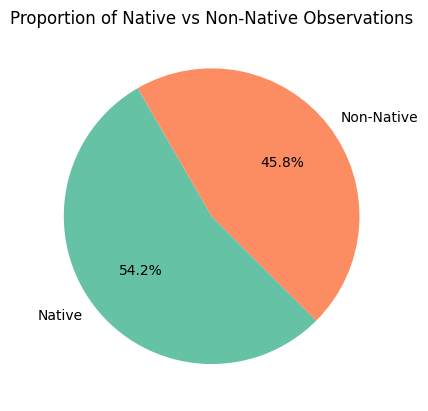

In [435]:
native_counts = obs_has_species['native'].value_counts().rename({True: 'Native', False: 'Non-Native'})

print(f'Number of native plant observations: {native_counts['Native']}')
print(f'Number of non-native plant observations: {native_counts['Non-Native']}')

colors = ['#66c2a5', '#fc8d62']

plt.pie(native_counts, labels=native_counts.index.astype(str), autopct='%1.1f%%', colors=colors, startangle=120)
plt.title("Proportion of Native vs Non-Native Observations");

## What are the most common native and non-native plants observed

In [436]:
obs_has_species.loc[obs_has_species['species'] == 'Impatiens capensis', 'native'] = True

In [437]:
native_obs = obs_has_species[obs_has_species['native'] == True]
nonnative_obs = obs_has_species[obs_has_species['native'] == False]

native_obs_byspecies = native_obs.groupby(['species', 'common_name']).size().sort_values(ascending=False).to_frame(name='count')
nonnative_obs_byspecies = nonnative_obs.groupby(['species', 'common_name']).size().sort_values(ascending=False).to_frame(name='count')

top10_native = native_obs_byspecies.nlargest(10, 'count')
top10_nonnative = nonnative_obs_byspecies.nlargest(10, 'count')

df1_html = top10_native.to_html()
df2_html = top10_nonnative.to_html()

display_html(f'<div style="display: flex; gap: 50px;"><div>{df1_html}</div><div>{df2_html}</div></div>', raw=True)


,,count
species,common_name,
Ageratina altissima,White snakeroot,119
Verbesina alternifolia,Wingstem,115
Symphyotrichum novae-angliae,New england aster,93
Impatiens capensis,Common jewelweed,90
Solidago caesia,Bluestem goldenrod,86
Asclepias syriaca,Common milkweed,82
Phytolacca americana,American pokeweed,80
Eupatorium serotinum,Late boneset,71
Lobelia cardinalis,Cardinal flower,66


### What are the most common invasive species?

In [438]:
invasive_obs = obs_has_species[obs_has_species['species'].apply(lambda x: first_two_words(x) in set(invasives['scientific_name']))]
invasive_byspecies = invasive_obs.groupby(['species', 'common_name']).size().sort_values(ascending=False)
display(invasive_byspecies.head(10))

species                common_name         
Lonicera maackii       Amur honeysuckle        70
Ailanthus altissima    Tree-of-heaven          66
Rosa multiflora        Multiflora rose         41
Lythrum salicaria      Purple loosestrife      35
Dipsacus fullonum      Wild teasel             21
Celastrus orbiculatus  Oriental bittersweet    19
Dipsacus laciniatus    Cutleaf teasel          19
Rhamnus cathartica     Common buckthorn        17
Morus alba             White mulberry          13
Pyrus calleryana       Callery pear            12
dtype: int64

## Observations by City

### Which cities have the highest number of obersvations?

Summary statistics for observations by city


,count
count,77.00
mean,100.79
std,211.64
min,1.00
25%,6.00
50%,27.00
75%,114.00
max,1480.00


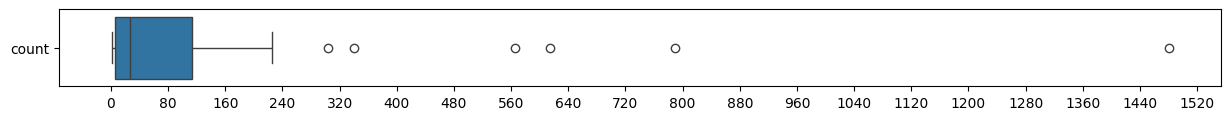

Top 20 cities


,count
City,
Cleveland,1480
North Olmsted,790
Brecksville,615
Parma,565
Strongsville,340
Walton Hills,304
Cleveland Heights,226
Mayfield,206
Shaker Heights,202


In [439]:
city_counts = obs_has_species.groupby('City').size().to_frame(name='count')

print('Summary statistics for observations by city')
display(city_counts.describe().round(2))

plt.figure(figsize=(15, 1))
sns.boxplot(data=city_counts, orient='h')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=25))

plt.show()

top20_cities = city_counts.nlargest(20, 'count')
print('Top 20 cities')
display(top20_cities)

### Which cities have the highest number of/proportion or native plants?
- Need to get number of native and non native plants per city as well as the total (which I already have)
- Some cities may have no natives or no nonnatives due to small sample sizes

In [440]:

natives_by_city = obs_has_species.groupby(['City', 'native']).size().to_frame(name='count')

natives_by_city_pivot = natives_by_city.reset_index().pivot_table(index='City', columns='native', values='count', fill_value=0).rename(columns={True: 'Native', False: 'Non-Native'})

merged = natives_by_city_pivot.merge(city_counts, on='City', how='left')

merged['percent_native'] = round((merged['Native'] / merged['count']) * 100,2)

merged = merged[merged['count']> 29]

merged= merged.sort_values(by=['percent_native', 'count'], ascending=False)

display(merged.describe())

display(merged)


,Non-Native,Native,count,percent_native
count,37.000000,37.000000,37.000000,37.000000
mean,88.837838,110.648649,199.486486,54.627027
std,141.772806,143.212782,274.236072,11.328361
min,10.000000,13.000000,30.000000,26.400000
25%,26.000000,31.000000,62.000000,47.260000
50%,54.000000,54.000000,114.000000,54.390000
75%,77.000000,102.000000,201.000000,63.080000
max,847.000000,633.000000,1480.000000,78.160000


,Non-Native,Native,count,percent_native
City,,,,
Mayfield,45.0,161.0,206,78.16
Bratenahl,10.0,23.0,33,69.70
Strongsville,104.0,236.0,340,69.41
Brook Park,63.0,138.0,201,68.66
North Olmsted,252.0,538.0,790,68.10
Brecksville,204.0,411.0,615,66.83
Parma Heights,21.0,41.0,62,66.13
Bentleyville,61.0,117.0,178,65.73
Walton Hills,109.0,195.0,304,64.14


### Which cities have the most invasive species?

In [448]:
invasive_bycity =invasive_obs.groupby('City').size().sort_values(ascending=False).to_frame('count')
invasive_bycity['pct'] = round((invasive_bycity['count'] / merged['count']) * 100, 2)

display(invasive_bycity.head(10))

,count,pct
City,,
Cleveland,102,6.89
Brecksville,35,5.69
Valley View,17,14.91
North Olmsted,16,2.03
Parma,15,2.65
Shaker Heights,12,5.94
Cleveland Heights,12,5.31
Walton Hills,10,3.29
Middleburg Heights,10,5.88


## Trends over time

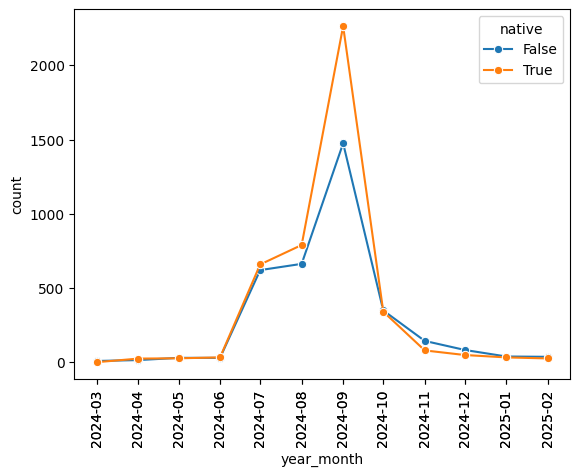

In [442]:
obs_has_species['year_month'] = obs_has_species['observed_on'].dt.to_period('M').dt.to_timestamp()

monthly_counts = obs_has_species.groupby(['year_month', 'native']).size().reset_index(name='count')

sns.lineplot(data=monthly_counts, x='year_month', y='count', hue='native', marker='o')
plt.xticks(ticks=monthly_counts['year_month'], labels=monthly_counts['year_month'].dt.strftime('%Y-%m'), rotation=90)
plt.show()

## Observation Grade
proprotion of native plants that are research grade. by_grade_native[true/research] / native_counts[native == native]
proporition of non native plants that are reserach grade

native_counts (native = Native or Non-Native)

In [443]:
by_grade = obs_has_species.groupby('quality_grade')['id'].count()
by_grade_native = obs_has_species.groupby(['native', 'quality_grade'])['id'].count()

display(by_grade.to_frame('count'))
display(by_grade_native.to_frame('count'))

pct_research = round(by_grade.loc['research'] / len(obs_has_species) * 100, 2)
pct_native_research = by_grade_native.loc[(True, "research")] / native_counts['Native']
pct_nonnative_research = by_grade_native.loc[(False, "research")] / native_counts['Non-Native']

print(f'Percent of all observations that are research grade: {pct_research}%')
print(f'Percent of native observations that are research grade: {round(pct_native_research * 100,2)}%')
print(f'Percent of non-native observations that are research grade: {round(pct_nonnative_research * 100,2)}%')

,count
quality_grade,
casual,504
needs_id,2857
research,4462


count
native quality_grade       
False  casual           422
       needs_id        1246
       research        1827
True   casual            82
       needs_id        1611
       research        2635

Percent of all observations that are research grade: 57.04%
Percent of native observations that are research grade: 62.18%
Percent of non-native observations that are research grade: 50.96%


In [444]:
count = np.array([by_grade_native.loc[(True, 'research')], by_grade_native.loc[(False, 'research')]])
nobs = np.array([native_counts.loc['Native'], native_counts.loc['Non-Native']])

z_stat, p_value = sm.stats.proportions_ztest(count, nobs, alternative='larger')

print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

Z-statistic: 9.98257754271824
P-value: 9.084233636211552e-24


## Plants Marked as Captive

### Are there differences in proportion of native plants between those marked captive and not?

In [445]:
captive_counts = obs_has_species['captive'].value_counts().to_frame(name='count')
display(captive_counts)

captive_native = obs_has_species.groupby(['captive', 'native']).size().to_frame(name='count')
display (captive_native)

pct_captive_native = round((captive_native.loc[(True, True), 'count'] / captive_counts.loc[True, 'count']) * 100, 2)
pct_notcaptive_native = round((captive_native.loc[(False, True), 'count'] / captive_counts.loc[False, 'count']) * 100, 2)

print(f'Percent native among those not marked captive: {pct_notcaptive_native}%')
print(f'Percent native among those marked captive: {pct_captive_native}%')

,count
captive,
False,7353
True,470


count
captive native       
False   False    3091
        True     4262
True    False     404
        True       66

Percent native among those not marked captive: 57.96%
Percent native among those marked captive: 14.04%


In [446]:
captive_obs = obs_has_species[obs_has_species['captive'] == True]
display(captive_obs.groupby('species').size().sort_values(ascending=False).head(10).reset_index(name='count'))

,species,count
0,Picea abies,16
1,Callicarpa dichotoma,15
2,Metasequoia glyptostroboides,14
3,Pinus strobus,14
4,Morella pensylvanica,13
5,Taxodium distichum,11
6,Pinus resinosa,9
7,Hydrangea quercifolia,9
8,Picea pungens,9
9,Cornus kousa,7
